<a href="https://colab.research.google.com/github/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/Topic_Modeling_with_BERTopic_Reclame_aqui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling with BERTopic - Reclame Aqui**

BERTopic is a topic modeling technique that leverages transformers and a custom class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions 

Reference: (https://maartengr.github.io/BERTopic/index.html).

### **Enabling the GPU**

We will use the GPU provided by COLAB to accelarate our model training. To enable GPUs for the notebook:
1- Navigate to Edit -> Notebook Settings
2- Select GPU from the Hardware Accelerator drop-down

In [2]:
# verify if GPU is enable
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan 11 14:12:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    28W /  70W |   1550MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Setup**

In [1]:
%%capture
try:
  import pandas as pd # for data manipulation
  import os # for interacting with the operating system
  import nltk # for natural language processing
  import string # for string manipulation
  import re # for for regular expressions
  import matplotlib.pyplot as plt # for visualization
  import spacy # for lemmatize portuguese text
  from bertopic import BERTopic # for topic modeling
  from spellchecker import SpellChecker # for spell check
  import json
  import optuna # for hyperparameter optimization
  from hdbscan import HDBSCAN # for clustering
  from sklearn.cluster import KMeans # for clustering
  from umap import UMAP # for dimension reduction
  from sklearn.decomposition import PCA # for dimension reduction
  from sklearn.feature_extraction.text import CountVectorizer # for convert text documents to matrix of tokens count
  from bertopic.vectorizers import ClassTfidfTransformer 
  import ast # for convert str to tuple
  import csv
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  import pickle 
  import pyLDAvis
  from gensim.utils import simple_tokenize
  from gensim.models import LdaMulticore
  from gensim.utils import simple_preprocess
except:
  !pip install pyspellchecker
  !pip install bertopic
  !pip install kaleido # for save BERTopic plots as image
  !pip install optuna
  !pip install hdbscan
  !pip install umap-learn
  !pip install gensim
  !pip install pyldavis
  import pyLDAvis
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  from gensim.utils import simple_tokenize
  from gensim.models import LdaMulticore
  from gensim.utils import simple_preprocess
  from umap import UMAP # for dimension reduction
  import optuna # for hyperparameter optimization
  from hdbscan import HDBSCAN # for clustering
  from bertopic import BERTopic # for topic modeling
  from bertopic.vectorizers import ClassTfidfTransformer 
  from spellchecker import SpellChecker # for spell check

In [ ]:
WORK_DIR = '/content/Topic-Modeling-Reclame-Aqui/'

In [31]:
DATA_FRAME_FEATURE_NAME = 'documents'

docs = pd.read_csv('./datasets/raw.csv')
print(docs[0:10])

['pesquisando bastante novo comprar resolver aguardar semana cliente porque ocorrer vários desconto promoção em esse semana ser assim recebi desconto cashback cupom varia plataforma assim decidir efetuar compra entender melhor custo beneficio ser assim setembro recebi oferta produto entendi preço além cachback efetuei comprar aguardei semana consumidor efetuar todo expectativa estavar ancioso estar dentro prazo entregar hoje resolver enviar mensagem perguntar pedir enviar após confirmação comprar pagamento passado dia nenhum retorno complei inclusive site confio tambem assinante surpresa após pedir informação pedir retorno email estar ser cancelar ser nenhum justificativa após dia realização aguardei chegar periodo compro ansiosamente aproveitar desconto produto familia aguardar além cancelar compra produto justificativa empresa tirar todo oportunidade desconto efetuar compra semano consumidor levar dia cancelar sinto extremamente empresa sempre acreditar aguardo satisfação reparação t

## **Training a BERTopic Model**

The BERTopic algorithm has several advantages over other topic modeling algorithms. It is able to handle sparse data, it is scalable to large datasets, and it is able to learn topics that are not well-defined or are overlapping.

As our data language is portuguese we will going to set language to multilingual.

Create a new BERTopic model and train it. By default BERTopic use the paraphrase-multilingual-MiniLM-L12-v2 model for multi language documents. For others model check here [BERTopic sentence transformers](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#sentence-transformers)

In [32]:
# Create a new BERTopic model using multilingual option
topic_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=True)

# Train model 
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/329 [00:00<?, ?it/s]

BERTopic works in three main steps: 


1.   Documents are first converted to numeric data. It extracts different embeddings based on the context of the word. For this, a sentence transformation model is used.
2.  Documents with similar topics are then grouped together forming clusters with similar topics. For this purpose, BERTopic uses the clustering algorithm UMAP to lower the dimensionality of the embeddings. Then the documents are clustered with the density-based algorithm HDBSCAN.
3. BERTopic extracts topics from clusters using a class-based TF-IDF score. This score gives the importance of each word in a cluster. Topics are then created based on the most important words measured by their C-TF-IDF score.

For more information check this link [BERTopic](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)



#### **BERTopic coherence score**

In [54]:
def get_bertopic_coherence(model, topics, docs):
    # preprocess Documents
    documents = pd.DataFrame({"Document": docs,
                          "ID": range(len(docs)),
                          "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = model._preprocess_text(documents_per_topic.Document.values)

    # extract vectorizer and analyzer from BERTopic
    vectorizer = model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # extract features for Topic Coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

    # evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
    return coherence_model.get_coherence()

In [47]:
print(f"Coeherence score: {get_bertopic_coherence(topic_model, topics, docs)}")

Coeherence score: 0.5140020610852358


### **Extracting Topics**

In [ ]:
# Print the most frequent topics
freq = topic_model.get_topic_info()

# Show the top 5 most frequent topics
freq.head(5)

The table above shows the five most freqeuente topics and the words present on it extract by BERTopic. -1 refers to all outliers and should be ignored.

In [ ]:
# show the most frequent topic
topic_model.get_topic(0)

**Note:** BERTopic is stocastich which means that the topics might differ across runs this is mostly due to the stocastisch nature of UMAP

#### **Save topic info table as CSV**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/topic_info_tables/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)

# Save table as csv
freq.head(10).to_csv(path + 'topic_info_preprocessed_lemma.csv', index=False)

## **Visualization**

### **Intertopic Distance Map**

This graph shows the distance intertopic and help us understand the promixity of topics

In [ ]:
fig = topic_model.visualize_topics(width=800, height=800)
fig

#### **Save intertopic distance map**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/intertopic_distance_map/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)


fig.write_image(path + "idm_preprocessed_lemma.png", format="png")
fig.write_html(path + "idm_preprocessed_lemma.html")

[Github link](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/results/intertopic_distance_map/idm_preprocessed_lemma.png?raw=true)

### **Visualize Topic Hierarchy**

The topics that were created can be hierarchically reduced. This visualization shows how the topics relate to one another.

In [ ]:
fig = topic_model.visualize_hierarchy(top_n_topics=30, width=800, height=800)
fig

#### **Save Hierarchical Clustering**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/hierarchical_clustering/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)


fig.write_image(path + "hc_preprocessed_lemma.png", format="png")

[Github link](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/results/hierarchical_clustering/hc_preprocessed_lemma.png?raw=true)

### **Visualize Terms**

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation.

In [ ]:
fig = topic_model.visualize_barchart(top_n_topics=12, width=300, height=300)
fig

#### **Save Top Word Scores Bar Chart**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/top_words_scores/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)


fig.write_image(path + "tws_preprocessed_lemma.png", format="png")

[Github link](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/results/top_words_scores/tws_preprocessed_lemma.png?raw=true)

### **Visualize Topic Similarity**

This plot shows a similarity matrix by simply applying cosine similarities through those topic embeddings generate by BERTopic through both c-TF-IDF and embeddings. This matrix indicate how similar certain topics are to each other.

In [ ]:
fig = topic_model.visualize_heatmap(n_clusters=20, width=800, height=800)
fig

#### **Save Similarity Matrix**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/similarity_matrix/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)


fig.write_image(path + "sm_preprocessed_lemma.png", format="png")

[Github link](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/results/similarity_matrix/sm_preprocessed_lemma.png?raw=true)

### **Visualize Term Score Decline**

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added.

In [ ]:
fig = topic_model.visualize_term_rank()
fig

#### **Save Term score decline per Topic**

In [ ]:
# Set the path to save 
path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/term_score_decline_topic/'

# Use makedirs() to create a new directory if it does not exists
if not os.path.exists(path):
  os.makedirs(path)


fig.write_image(path + "tsdp_preprocessed_lemma.png", format="png")

[Github link](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/results/term_socore_decline_topic/tsdp_preprocessed_lemma.png?raw=true)

### **Term search**

In [ ]:
# Find topics that contains blackfriday term
similar_topics, similarity = topic_model.find_topics("blackfriday", top_n=5)

# Show similar topics
similar_topics

In [ ]:
# Show a specific topic
topic_model.get_topic(64)

### **"Hiperparameter optimization"**

In [ ]:
def save_documents(model, docs, label):
  fig = topic_model.visualize_documents(docs, hide_document_hover=True, hide_annotations=True, width=800, height=800)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/documents_n_topics/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"document_n_topics_trial_{label}.png", format="png")
  fig.write_html(path + f"document_n_topics_trial_{label}.html")

In [ ]:
def save_topics(model, label):
  fig = model.visualize_topics(width=800, height=800)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/intertopic_distance_map/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"intertopic_distance_map_trial_{label}.png", format="png")
  fig.write_html(path + f"intertopic_distance_map_trial_{label}.html")

In [ ]:
def save_hierarchy(model, label):
  fig = model.visualize_hierarchy(width=800, height=800)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/hierarchical_clustering/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"hierarchical_clustering_trial_{label}.png", format="png")
  fig.write_html(path + f"hierarchical_clustering_trial_{label}.html")

In [ ]:
def save_top_words_scores(model, label):
  fig = model.visualize_barchart(top_n_topics=12, width=300, height=300)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/top_words_scores/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"top_words_scores_trial_{label}.png", format="png")
  fig.write_html(path + f"top_words_scores_trial_{label}.html")

In [ ]:
def save_similarity_matrix(model, label):
  fig = model.visualize_heatmap()

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/similarity_matrix/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"similarity_matrix_trial_{label}.png", format="png")
  fig.write_html(path + f"similarity_matrix_trial_{label}.html")

In [ ]:
def save_term_rank(model, label):
  fig = model.visualize_term_rank(width=800, height=800)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/term_score_decline_topic/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  fig.write_image(path + f"term_score_trial_{label}.png", format="png")
  fig.write_html(path + f"term_score_trial_{label}.html")

In [ ]:
def save_hyperparameters(trial_params, label):
  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/hyperparameters/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  with open(path + f"hyperparameters_trial_{label}.json", "w") as f:
    f.write(json.dumps(trial_params))

In [ ]:
def save_freq_topics(model, label):
  # Print the most frequent topics
  freq = topic_model.get_topic_info()

  # Show the top 5 most frequent topics
  freq = freq.head(5)

  # Set the path to save 
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/frequent_topics/' 

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  freq.to_html(path + f"freq_topics_trial_{label}.json")
  freq.to_csv(path + f"freq_topics_trial_{label}.csv", index=False)

In [ ]:
def save_model(model, label):
  # save model
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/models/'

  # Use makedirs() to create a new directory if it does not exists
  if not os.path.exists(path):
    os.makedirs(path)

  model.save(path + label)

In [ ]:
lda_scores = {'scores': []}
bertopic_scores = {'scores': []}
def save_coherence(model, topics, docs, label, clustering_model, reduction_model):
  
  # compute coherence score for BERTopic
  coherence_score = get_bertopic_coherence(model, topics, docs)
  bertopic_scores['scores'].append(coherence_score)
  print(f"Bertopic Coeherence score: {coherence_score}")

  # compute coherence score for LDA
  lda_score = get_lda_coherence_score(docs, len(topics))
  lda_scores['scores'].append(lda_score)
  print(f"LDA Coeherence score: {lda_score}")

  # save scores
  path = WORK_DIR + f'results/{DATA_FRAME_FEATURE_NAME}/coherence/'

  if not os.path.exists(path):
    os.makedirs(path)

  with open(path + 'coherence_scores.csv', 'a', newline='') as f:
    fieldnames = ['model', 'clustering', 'reduction', 'coherence_score', 'lda_coherence_score']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    data = [{'model': label,
             'clustering': clustering_model, 
             'reduction': reduction_model,
             'coherence_score': round(coherence_score, 4),
             'lda_coherence_score': lda_score}]
    writer.writerows(data)
  return coherence_score

In [ ]:
def visualize_lda(lda_model, nr_topics, corpus, id2word):
  path = WORK_DIR + 'results/lda/topics/ldavis_' + str(nr_topics)

  vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
 
  with open(path, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

  with open(path, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
  
  pyLDAvis.save_html(LDAvis_prepared, WORK_DIR + 'results/lda/topics/ldavis_'+ str(nr_topics) +'.html')
  LDAvis_prepared

In [ ]:
def plot_lda_coherences():
  # Create a list of the number of topics to test
  topic_range = range(2, 20)

  # Calculate the coherence scores for each number of topics
  coherence_scores = [get_lda_coherence_score(n_topics) for n_topics in topic_range]

  # Plot the coherence scores
  plt.plot(topic_range, coherence_scores)
  plt.xlabel('Number of Topics')
  plt.ylabel('Coherence Score')
  plt.show()

In [53]:
def get_topics(lda, nr_topics):
  x=lda.show_topics(num_topics=nr_topics, num_words=10,formatted=False)
  topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
  topics = []
  for t, _ in topics_words:
    topics.append(t)
  return topics

In [77]:
def get_words(lda, topics):
  words = []
  for topic_id, topic in enumerate(topics):
    topic_words = [dictionary[word_id] for word_id, prob in lda.get_topic_terms(topic_id, topn=10)]
    words.append(topic_words)
  return words

In [80]:
def get_lda_coherence_score(docs, nr_topics):

  # tokenize the text data
  tokens = [simple_preprocess(doc) for doc in docs]
  # create a corpus from a list of texts
  dictionary = Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]

  # create a new LDA model
  lda_model = LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=nr_topics,
                                       random_state=100)
  
  # save topics
  path = WORK_DIR + "result/lda_topics/"

  if not os.path.exists(path):
    os.makedirs(path)

  topics = get_topics(lda_model, nr_topics)
  print(topics)
  print(len(topics))

  topic_words = get_words(lda_model, topics)
  print(topic_words)
  print(len(topic_words))

  score = get_lda_coherence(lda_model, topics, docs)
  print(f'LDA coherence Score: ', score)
  return score

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
get_lda_coherence_score(docs, 10510)

In [ ]:
# define the number of models to generate by optuna
NUMBER_OF_MODELS = 4

In [ ]:
def optimizer(trial):

  clustering_option = trial.suggest_categorical('clustering_algorithm__name', ['HDBSCAN', 'K-means'])
  dimensionality_option = trial.suggest_categorical('reduction_algorithm__name', ['UMAP', 'PCA'])

  # BERTopic hyperparameters
  top_n_words = trial.suggest_int('bertopic__top_n_words', 5, 14)
  n_gram_range = ast.literal_eval(trial.suggest_categorical('bertopic__n_gram_range', ['(1,1)', '(1,2)', '(1,3)']))
  min_topic_size = trial.suggest_int('bertopic__min_topic_size', 15, 20)
  diversity = trial.suggest_float('bertopic__diversity', 0.1, 1.0)
  outlier_threshold = trial.suggest_float('bertopic__outliers_threshold', 0.04, 0.09)
  nr_topics = trial.suggest_int('bertopic__nr_topics', 6, 20, step=1)

  if clustering_option == 'HDBSCAN':
    # HDBSCAN hyperparameters
    min_cluster_size = trial.suggest_int('hdbscan__min_cluster_size', 10, 14)
    cluster_selection_epsilon = trial.suggest_float('hdbscan__cluster_selection_epsilon', 0.1, 1.0)

    # create a new HDBSCAN model to cluster documents
    clustering_model = HDBSCAN(min_cluster_size=min_cluster_size, prediction_data=True)
  elif clustering_option == 'K-means':
    # K-means hyperparameters
    k_means_n_clusters = trial.suggest_int('k-means__n_cluster',6, 10)

    # create a new HDBSCAN model to cluster documents
    clustering_model = KMeans(n_clusters=k_means_n_clusters)


  if dimensionality_option == 'UMAP':
    
    # UMAP hyperparameters
    n_neighbors = trial.suggest_int('umap__n_neighbors', 13, 17)
    n_components = trial.suggest_int('umap__n_components', 2, 8)
    metric = trial.suggest_categorical('umap__metric', ['cosine', 'euclidean'])
    min_dist = trial.suggest_float('umap__min_dist', 0.1, 1.0)
    spread = trial.suggest_float('umap__spread', 0.1, 1.0)

    # create a new UMAP model to reduce dimension
    reduction_model = UMAP(n_neighbors=n_neighbors, metric=metric, random_state=42)
  elif dimensionality_option == 'PCA':
    
    # PCA hyperparameters
    pca_n_components = trial.suggest_int('pca__n_components', 4, 6)
    
    # create a new PCA model to reduce dimension
    reduction_model = PCA(n_components=pca_n_components, random_state=12) # k-Means, that does not produce any outliers at all


  # CountVectorizer hyperparameters 
  max_features = trial.suggest_int('vectorizer__max_features', 3000, 6000)

  # reduce the impact of frequent words.
  ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

  # list of portuguese stop words + custom words
  stop_words = nltk.corpus.stopwords.words('portuguese') + custom_stop_words

  # create a new CountVectorizer to create a matrix of tokens count
  vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range=n_gram_range, max_features=max_features)


  # create a new BERTopic model using multilingual option
  model = BERTopic(language="multilingual", 
                   nr_topics=nr_topics,
                   calculate_probabilities=True, 
                   verbose=False,
                   top_n_words=top_n_words,
                   n_gram_range=n_gram_range,
                   min_topic_size=min_topic_size,
                   diversity=diversity,
                   umap_model=reduction_model,
                   hdbscan_model=clustering_model,
                   vectorizer_model=vectorizer_model,
                   ctfidf_model=ctfidf_model)
  
  try:
    label = trial.number
    params = trial.params
  
    # define model id
    model_id = f"model_trial_{label}"

    # train BERTopic model 
    topics, probs = model.fit_transform(docs)

    # save plots
    save_topics(model, label)
    save_documents(model, docs, label)
    save_hierarchy(model, label)
    save_term_rank(model, label)
    save_top_words_scores(model, label)
  
    # save model
    save_model(model, model_id)

    # save hyperparameters
    save_hyperparameters(params, label)

    # save model coherence score
    save_coherence(model, topics, docs, model_id,
                           clustering_option, dimensionality_option)
    
  except Exception as error:
    print(error)
  
  return 0.0

In [ ]:
%%time

# create a new study
study = optuna.create_study(study_name='Bertopic')

# run the optmize function 
study.optimize(optimizer, n_trials=NUMBER_OF_MODELS)

In [ ]:
def plot_coherence(model_label, nr_topics, coherences):
  topicsname=[]
  for i in range(1,nr_topics+1):
      topicsname.append("t{0}".format(i))
  topicsname

  plt.plot(topicsname, coherences)
  plt.xlabel("Number of Topics")
  plt.ylabel("Coherence score")
  plt.legend(("coherence_values"), loc='best')
  plt.show()

In [ ]:
label = "BERTopic"
plot_coherence(label, 20, bertopic_scores['scores'])

In [ ]:
label = "LDA"
plot_coherence(label, 20, lda_scores['scores'])

#### **Merge of similar topics**

In [ ]:
# TODO: select the best model and merge similar topic and save final model

#topic_model = BERTopic.load("best_model")

#### **Github**

In [ ]:
! ssh-keygen -t rsa -b 4096
# Add github.com to our known hosts
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# Restrict the key permissions, or else SSH will complain.
! chmod go-rwx /root/.ssh/id_rsa

In [5]:
! cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQC6/NSF77pXXyhyr6o4XWk+9GTfR4W9zDbFgE1LNVOeaGaAwmPJt1l8wjPZnhr703WVXXMCDsHqBxQfDLcnODYCkjpFBQrtwJOH5xTWtfTRkidyjz9jrA1zgNcl2TEoHS4DCWgaANiUvaC/lgq2hvaJ8/EvQmZrzSodkmlNONRomLLkiSbvpYBF6a5q77KOwvb4m3H28WT8DC/sptgc3j6ns5x3Zv9wYdl1Zl8XtjPWxeSVGyLqWwjWQ0exL32SQPSJTnShtGDvqdfvOmLBT6jBQLOvNeoJFIoxbcO+pZpiMlCbKPOnT4QsWaVyI/7zXJ+cougquqN2yUVlsp6RxFnnpexijw88jicUb3JAPc9DYu4CqQQ71NPmB9r8lGTncTPhECmcFwxpq42wzKNX97a28L1UJ6u4cCajMVG+LXe/n0mxP9nmOSGaPdQl6pHz9EJOp1f7wUv0svlRl4ulFelL61KDWe5i2ZX2bKidFP8KKGbH5dpVTy7+WnnPIFTUTrNt2KyBrV0uwwlxpdRx889hU9n7D8QAhsuCcoL+I1QaWFl29F5BvE0McjoG3V+RtGwPrxZUTpEv0Hf6AibjwExAVze0TDz0gK4hl+9ywXrJ+6/4Y/D0oxnncS0F8qMHlBoIj8KFe8XMUwMoyksmM544+2C4BDngtAodDGEhRfG45Q== root@d8d881f9a738


In [6]:
!git config --global user.email "mattheus_ribeiro@outlook.com"
!git config --global user.name "punkmic"

In [7]:
!ssh -T git@github.com

Hi punkmic! You've successfully authenticated, but GitHub does not provide shell access.


In [8]:
!git clone git@github.com:punkmic/Topic-Modeling-Reclame-Aqui.git

Cloning into 'Topic-Modeling-Reclame-Aqui'...
remote: Enumerating objects: 16308, done.
remote: Counting objects: 100% (2127/2127), done.
remote: Compressing objects: 100% (1859/1859), done.
Receiving objects: 100% (16308/16308), 127.24 MiB | 8.43 MiB/s, done.
remote: Total 16308 (delta 323), reused 1950 (delta 234), pack-reused 14181
Resolving deltas: 100% (1471/1471), done.
Checking out files: 100% (14808/14808), done.


In [ ]:
%cd /content/Topic-Modeling-Reclame-Aqui/

In [ ]:
!git add ./results/documents

In [ ]:
!git status

In [ ]:
!git commit -m "Adding preprocessed BERTopic result"

In [ ]:
!git push origin master

In [ ]:
# run this command to push a new version of this notebook in case you have saved the notebook in github and it is outdate 
!git stash
!git pull
!git stash pop

In [ ]:
!rm -rf /root/.ssh/

In [ ]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# convert text documents to bag of words representation
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=6000, stop_words='english', ngram_range=(1, 2))
x = vectorizer.fit_transform(docs)

# perform k-means clustering
kmeans = KMeans(n_clusters=20)
kmeans.fit(x)

KMeans(n_clusters=20)

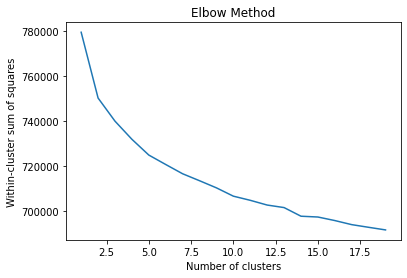

In [ ]:
# use elbow method to find the best number of clusters
ls = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x)
    ls.append(kmeans.inertia_)
plt.plot(range(1, 20), ls)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.show()